In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings
# We silence warnings concerning future version updates
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# Load training and testing data
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:, 1]

In [3]:
# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
def saveFile(y_pred,name):
    test_header = "Id,EpiOrStroma"
    n_points = X_test.shape[0]
    y_pred_pp = np.ones((n_points, 2))
    y_pred_pp[:, 0] = range(n_points)
    y_pred_pp[:, 1] = y_pred
    np.savetxt(name, y_pred_pp, fmt='%d', delimiter=",",
               header=test_header, comments="")


# Function used to preprocess the data with the Standard Scaler
def scalingFunction(X_train,X_test):
    sc = StandardScaler()

    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.fit_transform(X_test)
    return(X_train_scaled,X_test_scaled)

# GridSearch function for SVC. Parameter Grid refined after testing.
def gridSearch(trainData,y_train):
    
    param_grid = [
        {'kernel' : ['linear','rbf'],
         'gamma' :[1,0.1,0.001,0.0001],
         'C' : [0.0001, 0.001,0.01, 0.1, 1, 10, 100, 1000]},
    ]

    svcGrid = GridSearchCV(SVC(),param_grid,cv=10,refit = True)
    best_svc = svcGrid.fit(trainData, y_train)
    return(best_svc)

In [4]:
# Feature Selection for most important features

def featSelectERT(X_train,X_test,y_train,numberSelectedFeatures):
    #Method 1: Extremely randomised trees
    model = ExtraTreesClassifier()
    model.fit(X_train,y_train)
    # Selection and sorting of most important features.
    feat_scores = model.feature_importances_
    feat_indexes = np.argsort(feat_scores)
    top_indexes = feat_indexes[:numberSelectedFeatures]
    print("Selected",numberSelectedFeatures,"most important features with Extremely Randomised Trees.")
    # Creating new X_train and X_test sets with selected features
    X_train_M1 = np.empty([len(X_train),len(top_indexes)])
    X_test_M1 = np.empty([len(X_test),len(top_indexes)])
    counter = 0
    for index in top_indexes:
        X_train_M1[:,counter] = X_train[:,index]
        X_test_M1[:,counter] = X_test[:,index]
        counter += 1
    return(X_train_M1,X_test_M1)

def featReducPCA(X_train,X_test,numberSelectedFeatures):
    #Method 2: PCA reduction
    pca = PCA(n_components=numberSelectedFeatures)
    X_train_M2 = pca.fit_transform(X_train)
    X_test_M2 = pca.fit_transform(X_test)
    print("Selected",numberSelectedFeatures,"most important features with PCA.")
    return(X_train_M2,X_test_M2)

def featSelectVariance(X_train,X_test,varThreshold):
    #Method 3: Removing features with a variance lower than the given threshold
    sel = VarianceThreshold(threshold=(varThreshold * (1 - varThreshold)))
    X_train_M3 = sel.fit_transform(X_train)
    X_test_M3 = sel.fit_transform(X_test)
    print("Removed features with variance lower than the",varThreshold,"threshold.")
    return(X_train_M3,X_test_M3)

In [5]:
# SVC Classifier Implementation
svc = SVC().fit(X_train,y_train)
print('Parameters currently in use:')
print(svc.get_params())

Parameters currently in use:
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [6]:
# Evaluating our model with different feature selection methods, selecting a different number of features.
# We have selected precise numbers of features to match the number selected by threshold values
# It is only useful to run this cell for the following graph (evaluation purposes)
featNumbers = [80,82,85,88,90,92,95,98,100]
threshHoldValues = [0.5,0.81,0.84,0.92,0.95,0.96,0.975,0.9895,0.991]

FeatSelect1=np.zeros((len(featNumbers),2))
FeatSelect2=np.zeros((len(featNumbers),2))
FeatSelect3=np.zeros((len(featNumbers),2))

# We now build our SVC model with all feature selection methods, for various number of features.
# Running GridSearch on all combinations should only take a minute or so.
counter = 0
for featNumb in featNumbers:
    # Selection Method 1
    FeatSelect1[counter,0] = featNumb
    X_train_M1, X_test_M1 = featSelectERT(X_train,X_test,y_train,featNumb)
    X_train_M1, X_test_M1 = scalingFunction(X_train_M1, X_test_M1)
    best_SVC_M1 = gridSearch(X_train_M1,y_train)
    FeatSelect1[counter,1] = best_SVC_M1.score(X_train_M1, y_train)
    
    # Selection Method 2
    FeatSelect2[counter,0] = featNumb
    X_train_M2, X_test_M2 = featReducPCA(X_train,X_test,featNumb)
    X_train_M2, X_test_M2 = scalingFunction(X_train_M2, X_test_M2)
    best_SVC_M2 = gridSearch(X_train_M2,y_train)
    FeatSelect2[counter,1] = best_SVC_M2.score(X_train_M2, y_train)
    
    counter += 1


counter = 0
for THValue in threshHoldValues:
    # Selection Method 3
    X_train_M3, X_test_M3 = featSelectVariance(X_train,X_test,THValue)
    X_train_M3, X_test_M3 = scalingFunction(X_train_M3, X_test_M3)
    # The feature selection method is different so we get the shape to obtain the number of features
    FeatSelect3[counter,0] = X_train_M3.shape[1]
    best_SVC_M3 = gridSearch(X_train_M3,y_train)
    FeatSelect3[counter,1] = best_SVC_M3.score(X_train_M3, y_train)
    
    counter += 1

#print(FeatSelect1)
#print(FeatSelect2)
#print(FeatSelect3)

Selected 80 most important features with Extremely Randomised Trees.
Selected 80 most important features with PCA.
Selected 82 most important features with Extremely Randomised Trees.
Selected 82 most important features with PCA.
Selected 85 most important features with Extremely Randomised Trees.
Selected 85 most important features with PCA.
Selected 88 most important features with Extremely Randomised Trees.
Selected 88 most important features with PCA.
Selected 90 most important features with Extremely Randomised Trees.
Selected 90 most important features with PCA.
Selected 92 most important features with Extremely Randomised Trees.
Selected 92 most important features with PCA.
Selected 95 most important features with Extremely Randomised Trees.
Selected 95 most important features with PCA.
Selected 98 most important features with Extremely Randomised Trees.
Selected 98 most important features with PCA.
Selected 100 most important features with Extremely Randomised Trees.
Selected 1

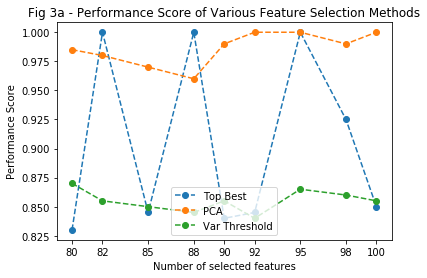

In [7]:
# Visualisation of results for the initial evaluation
plt.plot(FeatSelect1[:,0],FeatSelect1[:,1],'o--',)
plt.plot(FeatSelect2[:,0],FeatSelect2[:,1],'o--',)
plt.plot(FeatSelect3[:,0],FeatSelect3[:,1],'o--',)

plt.xticks(FeatSelect1[:,0])
plt.legend(["Top Best","PCA","Var Threshold"], loc='lower center')
plt.title("Fig 3a - Performance Score of Various Feature Selection Methods")
plt.xlabel("Number of selected features")
plt.ylabel("Performance Score")
plt.show()

In [8]:
# Actual Kaggle scores obtained for testing previously evaluated methods
featNumbersKaggle = [80,90,100,110]
# Training and testing sets did not always have the same shape given the same threshold
# We have selected values that generate X_train and X_test sets with the same number of features
featNumbersKaggleM3 = [80,88,95,110]

Method1Kaggle = np.zeros((4,2))
Method2Kaggle = np.zeros((4,2))
Method3Kaggle = np.zeros((4,2))

Method1KaggleScores = [0.84518,0.85355,0.86192,0.88702]
Method2KaggleScores = [0.61924,0.69874,0.66108,0.64435]
Method3KaggleScores = [0.86192,0.82845,0.86610,0.85355]


for i in range(4):
    Method1Kaggle[i,0]=featNumbersKaggle[i]
    Method1Kaggle[i,1]=Method1KaggleScores[i]
    
    Method2Kaggle[i,0]=featNumbersKaggle[i]
    Method2Kaggle[i,1]=Method2KaggleScores[i]
    
    Method3Kaggle[i,0]=featNumbersKaggleM3[i]
    Method3Kaggle[i,1]=Method3KaggleScores[i]
    
print(Method1Kaggle)
print(Method2Kaggle)
print(Method3Kaggle)

[[ 80.        0.84518]
 [ 90.        0.85355]
 [100.        0.86192]
 [110.        0.88702]]
[[ 80.        0.61924]
 [ 90.        0.69874]
 [100.        0.66108]
 [110.        0.64435]]
[[ 80.        0.86192]
 [ 88.        0.82845]
 [ 95.        0.8661 ]
 [110.        0.85355]]


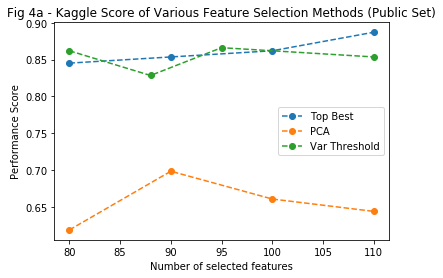

In [9]:
plt.plot(Method1Kaggle[:,0],Method1Kaggle[:,1],'o--',)
plt.plot(Method2Kaggle[:,0],Method2Kaggle[:,1],'o--',)
plt.plot(Method3Kaggle[:,0],Method3Kaggle[:,1],'o--',)

plt.legend(["Top Best","PCA","Var Threshold"], loc='center right')
plt.title("Fig 4a - Kaggle Score of Various Feature Selection Methods (Public Set)")
plt.xlabel("Number of selected features")
plt.ylabel("Performance Score")
plt.show()

In [10]:
# Selection of feature selection method and number based on results - SVC
# This will produce our predictions with the most potential to be submitted (not highest score).
# Variance Threshold: Selection Method 3
X_train_final, X_test_final = featSelectVariance(X_train,X_test,0.87)
X_train_final, X_test_final = scalingFunction(X_train_final, X_test_final)
# The feature selection method is different so we get the shape to obtain the number of features
best_SVC_final = gridSearch(X_train_final,y_train)
print("GridSearch results:",best_SVC_final.best_params_)
print("Shape:",X_train_final.shape)
print("Score:",best_SVC_final.score(X_train_final, y_train))
y_pred_submitted = best_SVC_final.predict(X_test_final)
#saveFile(y_pred_submitted,"finalSVC.csv")

Removed features with variance lower than the 0.87 threshold.
GridSearch results: {'C': 0.001, 'gamma': 1, 'kernel': 'linear'}
Shape: (200, 86)
Score: 0.855


In [11]:
# In-Depth Evaluation of most promising combinations for SVC: 
#we need to split the data for further evaluation of our model
X_trainSPLIT, X_testSPLIT, y_trainSPLIT, y_testSPLIT = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

print("training samples: ", len(X_trainSPLIT))
print("testing samples: ", len(X_testSPLIT))

new_X_train, new_X_test = featSelectVariance(X_trainSPLIT,X_testSPLIT,0.87)
new_X_train, new_X_test = scalingFunction(new_X_train, new_X_test)
SVC_eval = gridSearch(new_X_train,y_trainSPLIT)
print("GridSearch results:",SVC_eval.best_params_)
print("Shape:",new_X_train.shape)
print("Score:",SVC_eval.score(new_X_train, y_trainSPLIT))
y_pred = SVC_eval.predict(new_X_test)
#saveFile(y_pred,"testSVC.csv")

training samples:  160
testing samples:  40
Removed features with variance lower than the 0.87 threshold.
GridSearch results: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Shape: (160, 86)
Score: 0.975


In [12]:
# Computing Final Evaluation Metrics for selected Model
print("Accuracy of selected SVC Model:",accuracy_score(y_testSPLIT,y_pred))
print("F1 Score of selected SVC Model:",f1_score(y_testSPLIT,y_pred))
print("Avg. Precision of selected SVC Model:",average_precision_score(y_testSPLIT,y_pred))
print("Precision of selected SVC Model:",precision_score(y_testSPLIT,y_pred))
print("Recall of selected SVC Model:",recall_score(y_testSPLIT,y_pred))

Accuracy of selected SVC Model: 0.85
F1 Score of selected SVC Model: 0.8125
Avg. Precision of selected SVC Model: 0.33659420289855074
Precision of selected SVC Model: 0.7647058823529411
Recall of selected SVC Model: 0.8666666666666667
